In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 13 08:39:59 2022
Run after "NPM_2NIDAQalign"
To align pre-processed/trial-organised photometry data to model-fitting done in DataJoint 
Dependency:UtilFunctions_KH (_get_independent_variableKH; align_phys_to_behav_trials)
@author: Kenta M. Hagihara @SvobodaLab
"""

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

import json
json_open = open('../../dj_local_conf.json', 'r') 
config = json.load(json_open)

import datajoint as dj
dj.config['database.host'] = config["database.host"]
dj.config['database.user'] = config ["database.user"]
dj.config['database.password'] = config["database.password"]
dj.conn().connect()

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline import ophys
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice

from UtilFunctions_KH import _get_independent_variableKH, align_phys_to_behav_trials

/home/map/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


Connecting pochen@datajoint.mesoscale-activity-map.org:3306


In [2]:
DATA_ROOT_DIR = '/home/map/map-ephys/data/nm_data'
ANA_DIR = 'testdata_photometry_0727/'
ana_dir_path = os.path.join(DATA_ROOT_DIR, ANA_DIR)

NM_TRACES_DIR = 'result'
nm_traces_dir_path = os.path.join(ana_dir_path, NM_TRACES_DIR)
df = pd.read_pickle(os.path.join(nm_traces_dir_path, 'data_frame.pkl'))

sess_key = {'subject_id': 627713, 'session': 23}

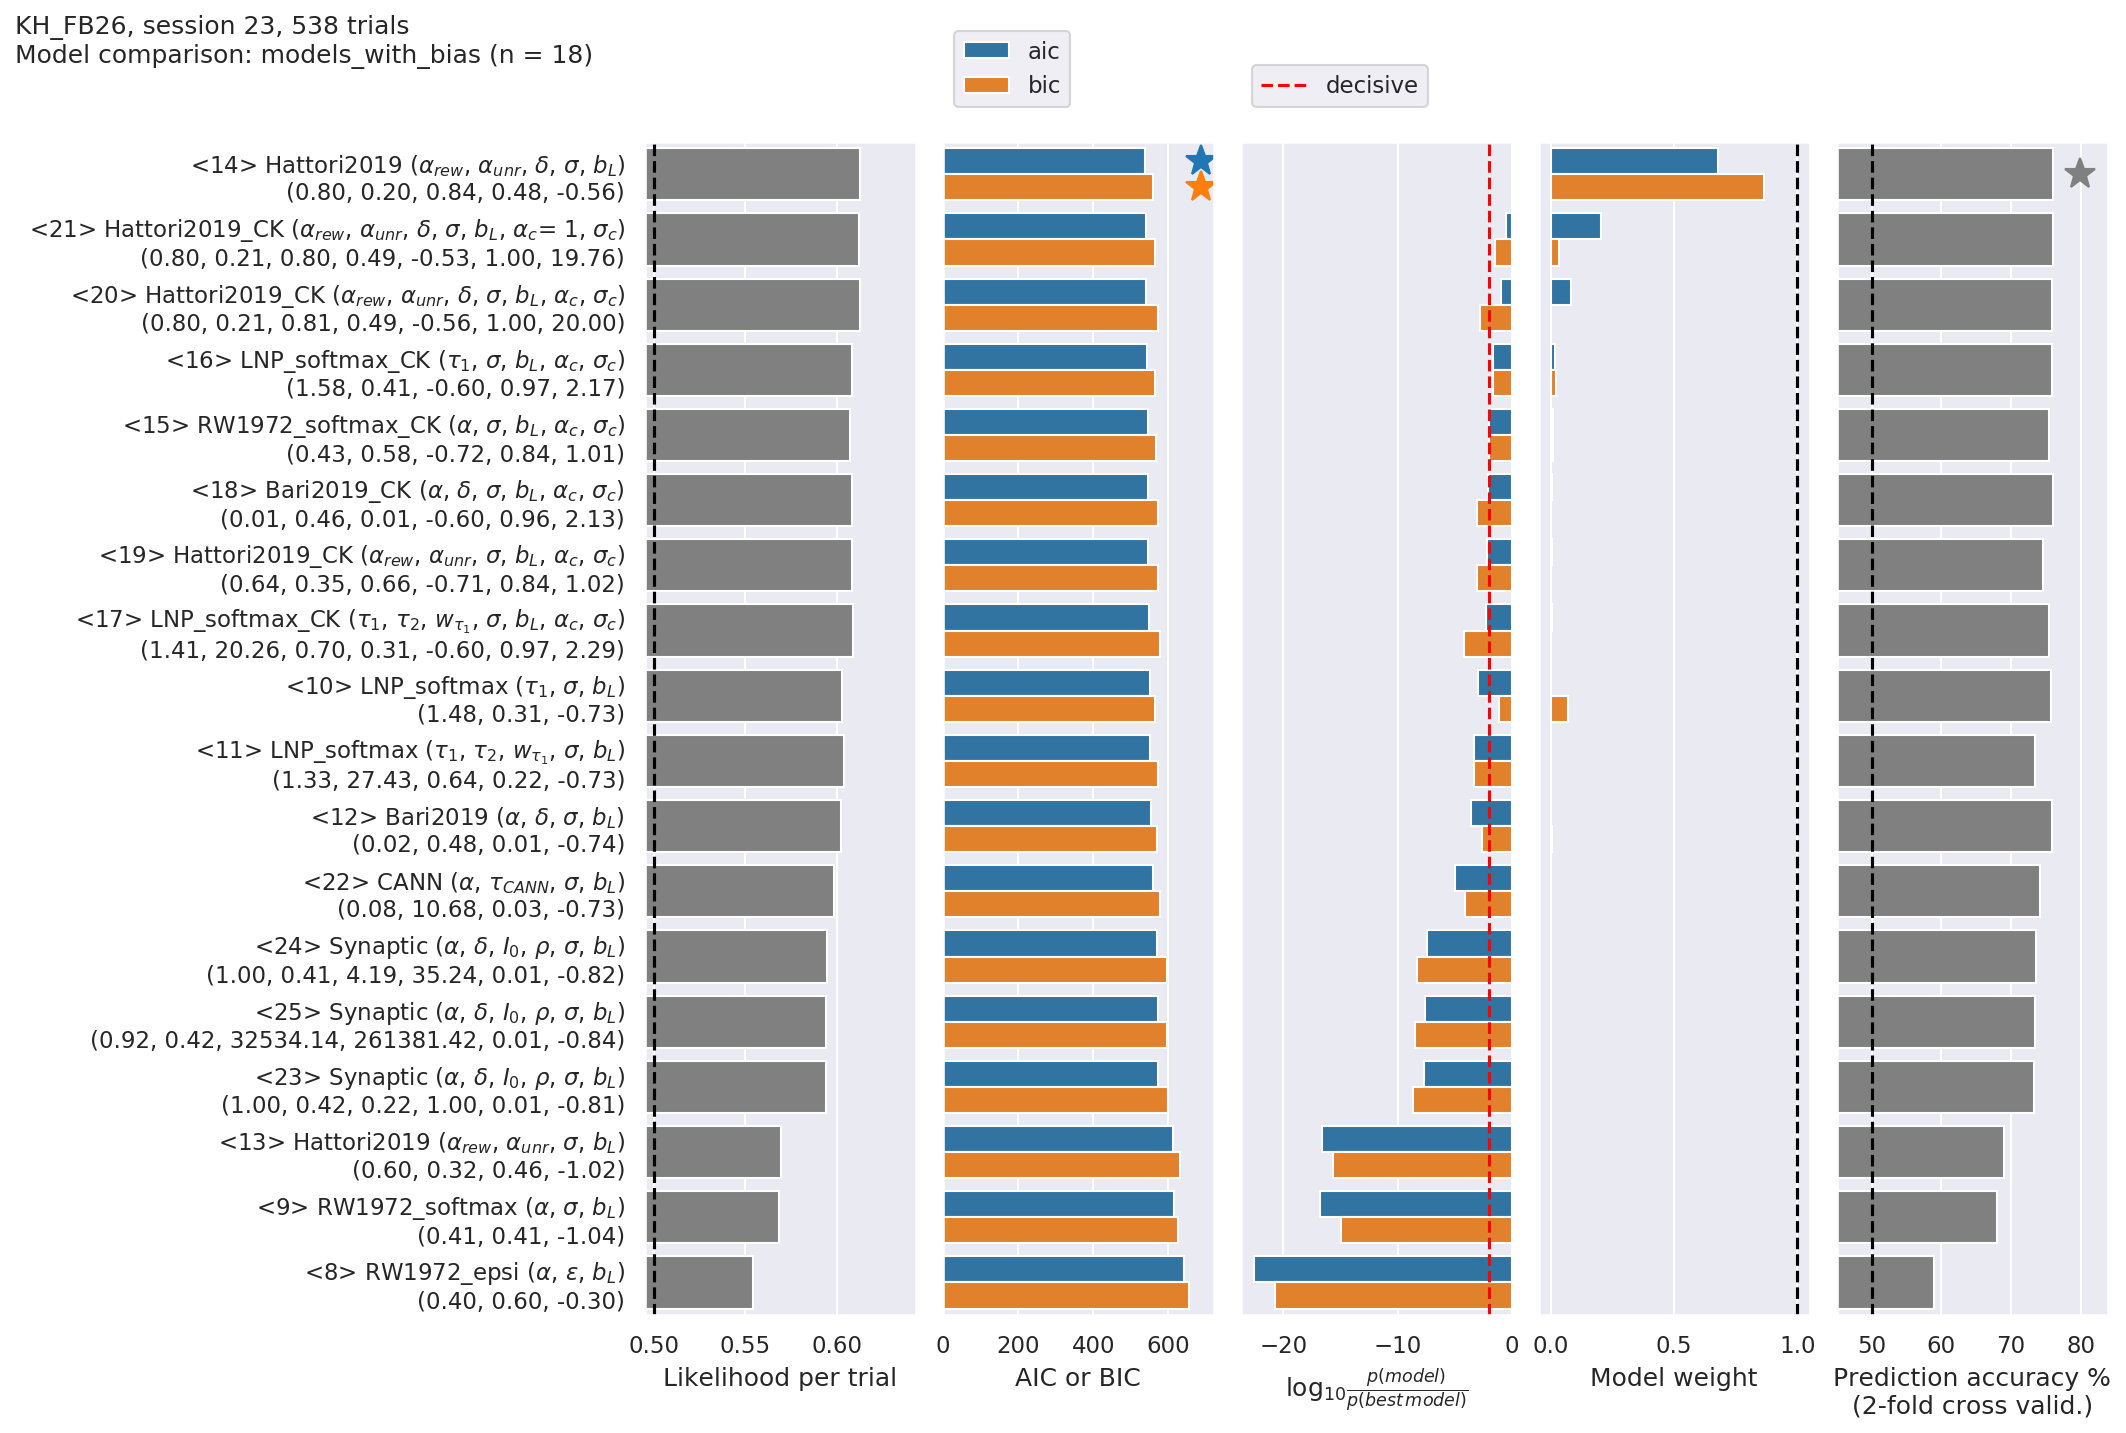

In [3]:
# Model List (ID + details)
foraging_model.Model()
plot_session_model_comparison(sess_key, model_comparison_idx=1, sort='aic')

model_id = 16 # LNP Sugrue/Newsome as a default for now

# read LVs
LatVars=_get_independent_variableKH(sess_key, model_id=model_id, var_name=None)

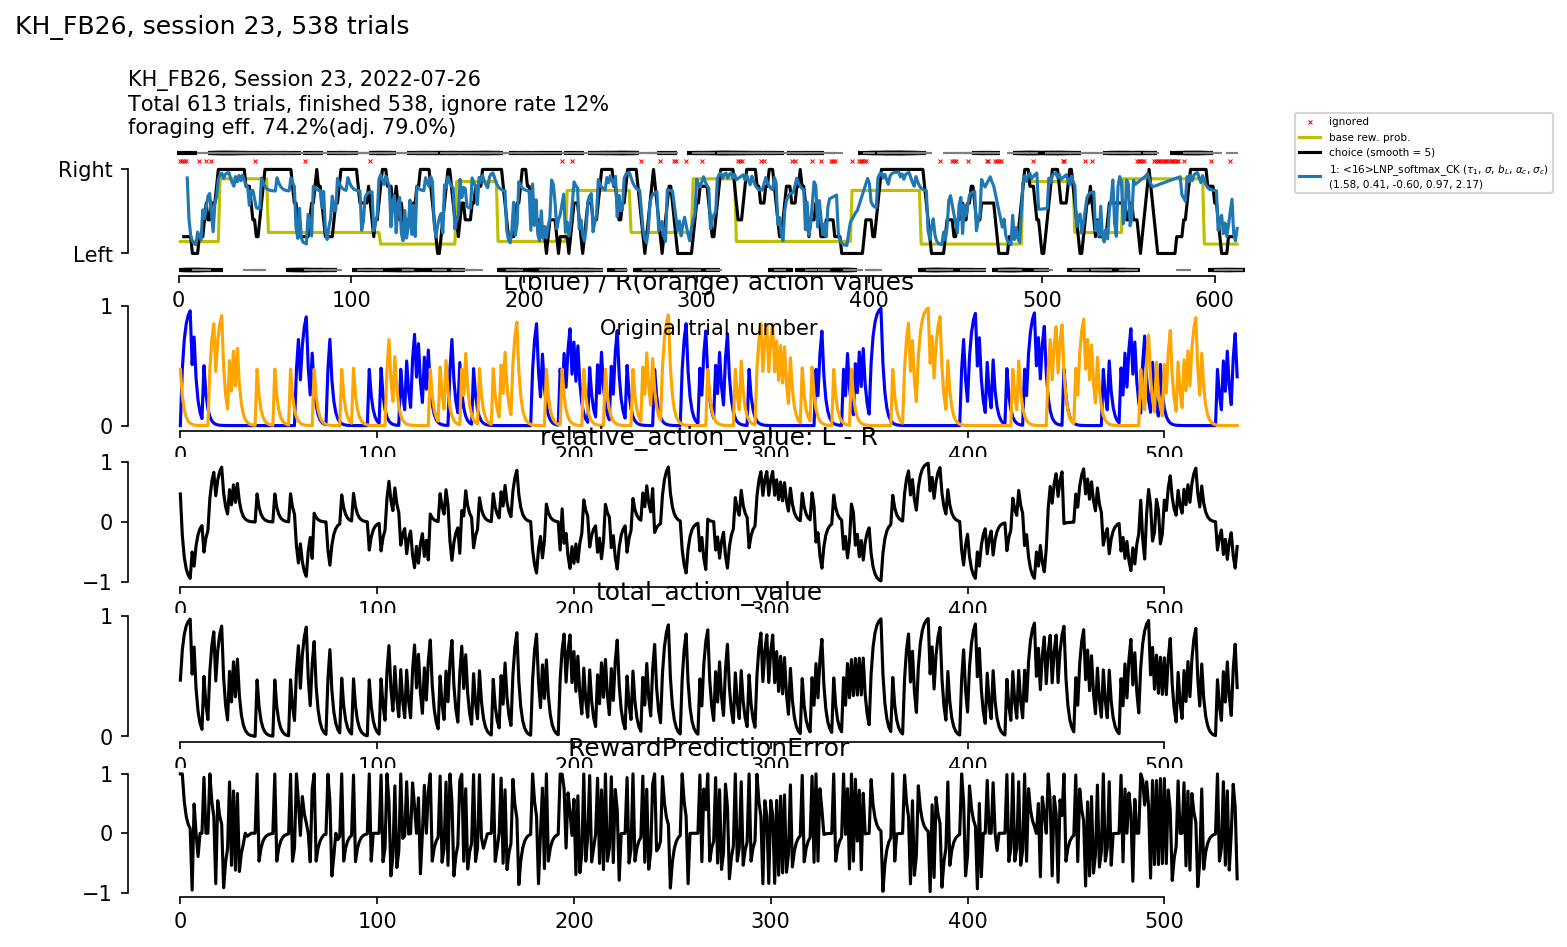

In [5]:
plt.figure(figsize=(10, 8), dpi=150)
plt.subplot(6,1,2)
plt.plot(LatVars['left_action_value'],color='blue')
plt.plot(LatVars['right_action_value'],color='orange')
plt.title('L(blue) / R(orange) action values')

plt.subplot(6,1,3)
plt.plot(LatVars['relative_action_value_lr'],color='black')
plt.title('relative_action_value: L - R')

plt.subplot(6,1,4)
plt.plot(LatVars['total_action_value'],color='black')
plt.title('total_action_value')

plt.subplot(6,1,5)
plt.plot(LatVars['rpe'],color='black')
plt.title('RewardPredictionError')

ax = plt.subplot(6,1,1)
plot_session_fitted_choice(sess_key, specified_model_ids=16, ax=ax, remove_ignored=False)
# plt.tight_layout()

In [6]:
# Trial Align

ophys_barcode = df['Barcode'].tolist() # This is so far manually imported from the photometry standalone
behav_trialN, behav_barcode = (experiment.TrialNote & sess_key & 'trial_note_type = "bitcode"').fetch('trial', 'trial_note', order_by='trial')

trial_aligned = align_phys_to_behav_trials(ophys_barcode, list(behav_barcode), list(behav_trialN))

mp = trial_aligned['phys_to_behav_mapping']

df_aligned = df.iloc[0:0]
LatVars_aligned = LatVars.iloc[0:0]

for ii in range(len(mp)):
    ophys_trial_this = mp[ii][0]-1  # note ophys is pd-row index-based
    behave_trial_this= mp[ii][1]
    
    if any(LatVars['trial'] == behave_trial_this):      # when false, ignored trial (no latent variables)
        df_aligned = df_aligned.append(df.iloc[ophys_trial_this,:])
        LatVars_aligned = LatVars_aligned.append(LatVars[LatVars['trial'] == behave_trial_this])

In [7]:
print(df_aligned.shape)
print(LatVars_aligned.shape)

(533, 13)
(533, 29)


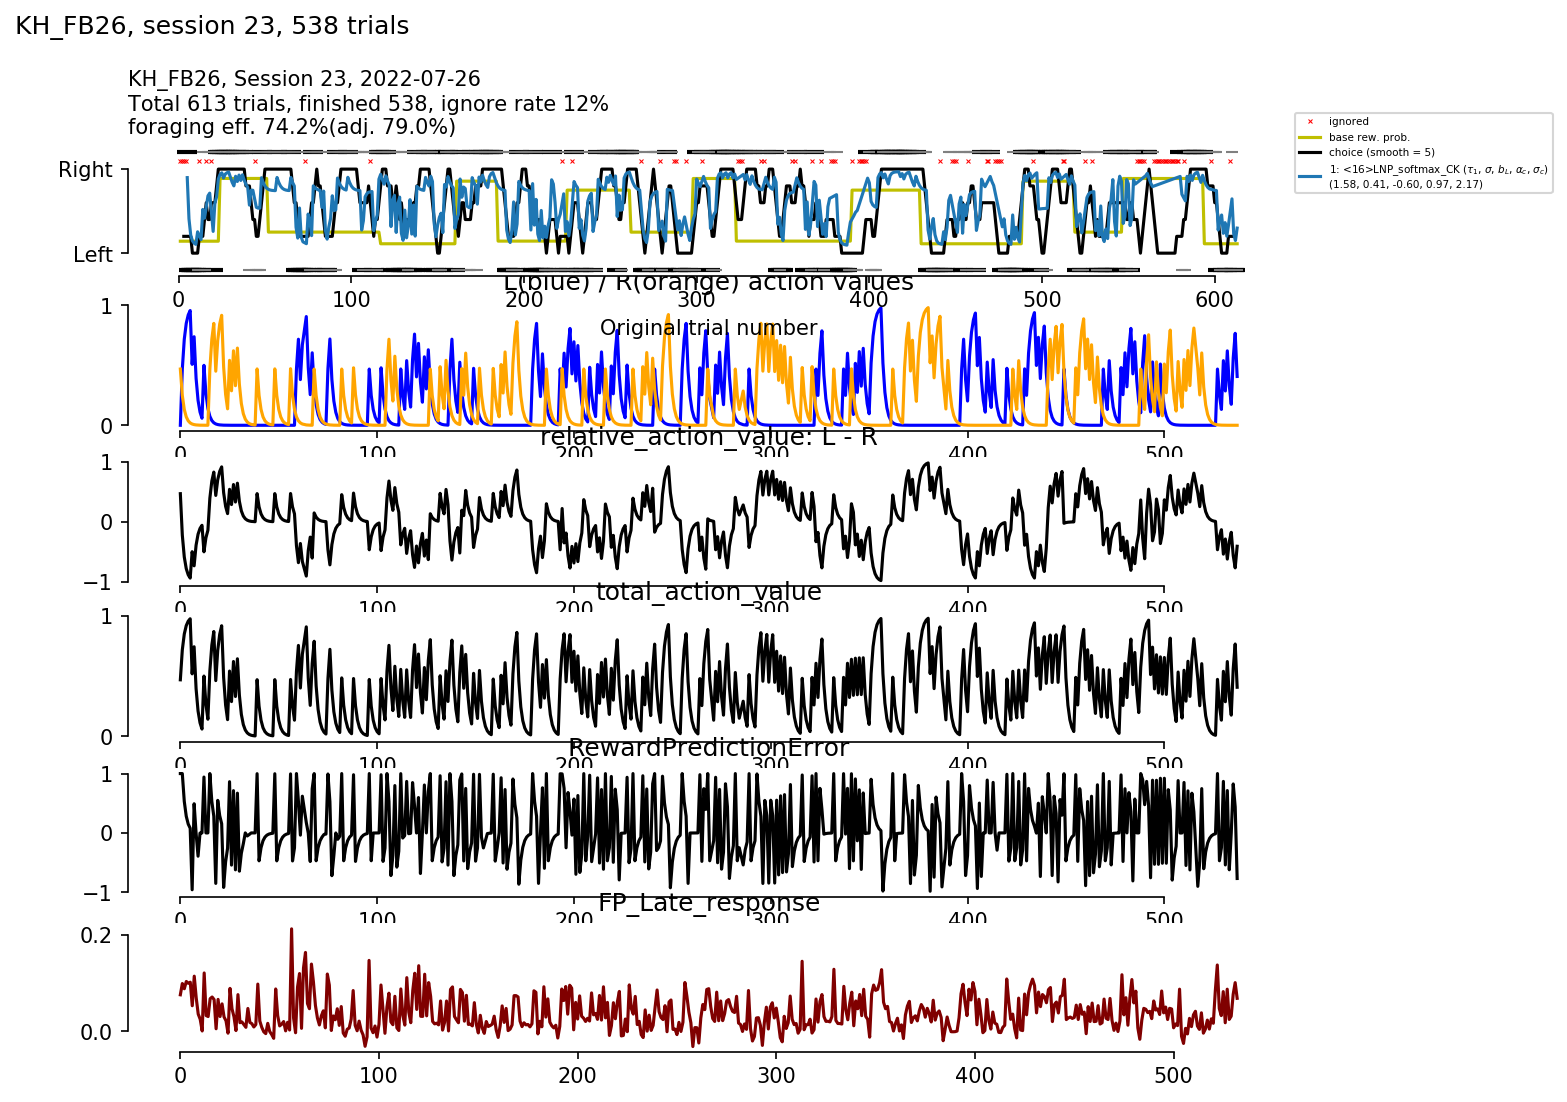

In [8]:
#%%
plt.figure(figsize=(10,8), dpi=150)
plt.subplot(6,1,2)
plt.plot(LatVars_aligned['left_action_value'], color='blue')
plt.plot(LatVars_aligned['right_action_value'], color='orange')
plt.title('L(blue) / R(orange) action values')

plt.subplot(6,1,3)
plt.plot(LatVars_aligned['relative_action_value_lr'],color='black')
plt.title('relative_action_value: L - R')

plt.subplot(6,1,4)
plt.plot(LatVars_aligned['total_action_value'],color='black')
plt.title('total_action_value')

plt.subplot(6,1,5)
plt.plot(LatVars_aligned['rpe'],color='black')
plt.title('RewardPredictionError')


temp = df_aligned['Resp_l']
Y_this=[]
for item in temp:
    Y_this = np.append(Y_this, item[3])

plt.subplot(6,1,6)
plt.plot(Y_this, color='maroon')
plt.title('FP_Late_response')

ax = plt.subplot(6,1,1)
plot_session_fitted_choice(sess_key, specified_model_ids=16, ax=ax, remove_ignored=False)

Text(0, 0.5, 'Late_response')

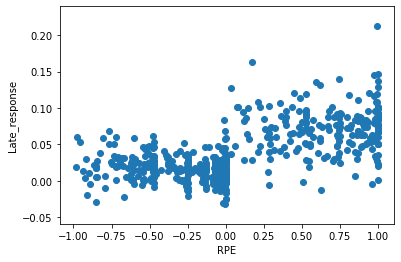

In [9]:
temp = df_aligned['Resp_l']
Y_this=[]
for item in temp:
    Y_this = np.append(Y_this, item[3])

plt.figure()
plt.scatter(LatVars_aligned['rpe'],Y_this)
plt.xlabel('RPE')
plt.ylabel('Late_response')

Text(0, 0.5, 'Reward_response')

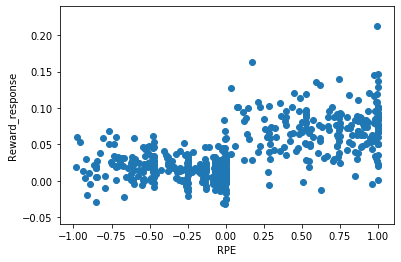

In [10]:
plt.figure()

temp = df_aligned['Resp_l']
Y_this=[]
for item in temp:
    Y_this = np.append(Y_this, item[3])

plt.scatter(LatVars_aligned['rpe'],Y_this)
plt.xlabel('RPE')
plt.ylabel('Reward_response')

Text(0, 0.5, 'ITI_response')

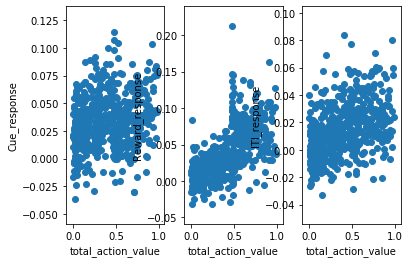

In [11]:
plt.figure()

temp = df_aligned['Resp_e']
Y_this=[]
for item in temp:
    Y_this = np.append(Y_this, item[3])

plt.subplot(1,3,1)
plt.scatter(LatVars_aligned['total_action_value'],Y_this)
plt.xlabel('total_action_value')
plt.ylabel('Cue_response')


temp = df_aligned['Resp_l']
Y_this=[]
for item in temp:
    Y_this = np.append(Y_this, item[3])

plt.subplot(1,3,2)
plt.scatter(LatVars_aligned['total_action_value'],Y_this)
plt.xlabel('total_action_value')
plt.ylabel('Reward_response')

#%
temp = df_aligned['Resp_t']
Y_this=[]
for item in temp:
    Y_this = np.append(Y_this, item[3])

plt.subplot(1,3,3)
plt.scatter(LatVars_aligned['total_action_value'],Y_this)
plt.xlabel('total_action_value')
plt.ylabel('ITI_response')